### 此為ipynb檔案包含Markdown，並額外附有Report.pdf提供資料流程說明與驗證測資

- Part  I: Cosine Similarity RDD

    成功輸出

- Part II: 推薦系統設計

    成功輸出  不穩定，可於步驟分開執行

    
- Part III (1): 利用Model Based重寫Part II - ALS


In [1]:
"""
PartI : Cosine Similarity RDD
"""
from pyspark.sql import SparkSession
import os
import sys
from pyspark.context import SparkContext,SparkConf
from pyspark.rdd import RDD
!pip install psutil
import psutil
import math
import operator
import time
#若沒有下面這段
#會有Exception: Java gateway process exited before sending its port number
#Config
os.environ['JAVA_HOME'] = 'C:\Program Files\Java\jre1.8.0_301'
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable



sc = SparkContext(conf=SparkConf().setAppName("Recommendation")\
                  .setMaster("local[6]")\
                  .set("spark.executor.heartbeatInterval","200000")\
                 .set("spark.network.timeout", "10000000"))
                                                 
#setting - heartbeatInterval","200000"  "200k ms"
#   "spark.network.timeout", "300000"   "400k ms"
print(f'sc:{sc}')
spark = SparkSession(sc)

You should consider upgrading via the 'c:\users\leoshr\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


sc:<SparkContext master=local[6] appName=Recommendation>


# 進行normalized的重要函式

In [2]:
#New method
#測試資料rdd = sc.parallelize([('b',1),('b',2), ('a',3),('a',4),('a',11)])

def mean_of_RatingPerUser(rdd):
    Tupleee =  ( 0 , 0 ) 
    """
    取得該user rating 的平均值
    input: [('b user', 1), ('b user', 2), ('a user', 3), ('a user', 4), ('a user', 11)]
    
    Iwanttosleep: [('b user', (3, 2)), ('a user', (18, 3))] # 前者是sum, 後者是number count
  
    output: [('b', 1.5), ('a', 6.0)]
    以上皆為RDD
    """
    Iwanttosleep = rdd.aggregateByKey ( Tupleee , lambda x , y :  ( x[0]+ y ,  x[1]+1 ) , 
                                       lambda x , y :  ( x[0]  + y[0] , x[1]+y[1] ) )
    fuckmylife = Iwanttosleep . mapValues ( lambda v : v [0] / v[1] )
    return fuckmylife   

def NL_user_rating(RDD1):
    """
    Input: userID必須當key [(userID), (movie_id, rating)]
    RDD1: 目標是利用paired_RDD直接進行正則化，其傳入之RDD應為所有user對movie對應的rating
    format:key [(userID), (movie_id, rating)]
                [('1',    ('1',        4.0)),
                 ('4',    ('1',        5.0)),
                 ('5',    ('1',        1.0)),...]
    
    
    RDD2: 由RDD1轉化而成， 原本為符合mean_of_RatingPerUser函式需求的RDD format, 目的是找出mean。
    input format: [('b', 1), ('b', 2), ('a', 3), ('a', 4), ('a', 11)] 
    
    
    Output:
    [(userID, (Movie_ID, Normalized_rating_score)),(...)...(...)]
    """
    #mean_per_user的誕生
    temp1 = RDD1.map(lambda x : (x[0], (x[1][1]))) #format change以符合mean_of_RatingPerUser input要求
    mean_per_user = mean_of_RatingPerUser(temp1)#跳去mean_of_RatingPerUser做工
    
    #Merge & reformat 
    #將format 從(user_id, (movie_id, movie_ratng),user_average_rating)
    #into       (user_id, (movie_id, movie_ratng,user_average_rating))
    temp2 = RDD1.join(mean_per_user).map(lambda x :(x[0], (x[1][0][0],x[1][0][1],x[1][1]))) 
    
    #將rating_score - (mean of rating score per user-based)
    result = temp2.map(lambda x:(x[0], (x[1][0],x[1][1]-x[1][2])))
    return result 

In [3]:
ratings_file_path = 'C:\\Users\\LeoShr\\p_space\\NTHU\\MDA\\Team Project\\Dataset\\ml-latest-small\\' + 'ratings.csv'

#ratings_file_path = r'C:\\Users\\LeoShr\\p_space\\NTHU\\MDA\\Team Project\\Dataset\\mini_dataset_latest\\' + 'ratings_test.csv'

#ratings_file_path = 'C:\\Users\\LeoShr\\p_space\\NTHU\\MDA\\Team Project\\Dataset\\mini_dataset_latest\\' + 'three_rating.csv'


#### 這個block常常用run all會error，要手動，原因不明
如果socket write error，重新執行一次

In [5]:
ratings_raw_data = sc.textFile(ratings_file_path)

#去除header
header_ratings = ratings_raw_data.take(1)[0]
header_ratings #string

#讀入ratings_raw_data，其是用list裝所有element，並用逗號分割的，因此我們要將它分開line.split(",")，並轉成paired RDD
ratings_data_RDD = ratings_raw_data.filter(lambda line: line != header_ratings).map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2])))
ratings_data_pairedRDD = ratings_data_RDD.map(lambda x: (x[0], (x[1], x[2])))
#ratings_data_pairedRDD 格式為: userID, movie_id, rating



#第23版更動，論文提到要做normalized
user_based_Nlrating = NL_user_rating(ratings_data_pairedRDD)
#user_based_Nlrating = ratings_data_pairedRDD
user_based_Nlrating.cache()
#格式: 'userId, (movie_id, rating) ，以user為key原因是要根據每位user的rating做normalized

PythonRDD[17] at RDD at PythonRDD.scala:53

In [6]:
#將userbased轉成item-based
#[(userID, (movieID, rating))] -> [(movieID, (userID, rating))] 
print(' [(movieID, (userID, rating))] ')
item_based_rating = user_based_Nlrating.map(lambda x: (x[1][0],(x[0],x[1][1])))


 [(movieID, (userID, rating))] 


## 分子 numerator

因為我們要算item based的cosine similarity，為兩個movie的向量相乘，而分子只有當同一個user評價兩部不同的電影時，才會進行相乘，因此，我們能夠利用此規則，將(userID, (movieID, normalized_rating)) self-join, 得到每位user同時有評價的電影關係。



1. 再將自己對自己的關係去除 filter.out

2. 任何一部電影被normailized後rating 恰好為0的部分不能去除，因為它們並非代表空值，而是代表該user對該電影的評分向量加乘，而之後計算可以讓其cosine simalarity == 0 ，但是不能去除，因為cosine最小為-1，他們比-1大。

3. 直接進行rating 相乘， 並[(movieID, movie_ID),(rating乘積)]

In [7]:
user_based_Nlrating.take(1)

[(4, (21, -0.5555555555555554))]

# 分子部分

In [8]:
cleanJoin_user_based = user_based_Nlrating.join(user_based_Nlrating).filter(lambda x : (x[1][0][0] < x[1][1][0]))
nominator = cleanJoin_user_based.map(lambda x : ((x[1][0][0], x[1][1][0]), (x[1][0][1] * x[1][1][1])))
numerator_sum  = nominator.reduceByKey(lambda x , y : x+y)

# numerator_sum.take(10)


# 分母部分

In [9]:
#將其進行平方
denominator2 = cleanJoin_user_based.map(lambda x : ((x[1][0][0], x[1][1][0]), (math.pow(x[1][0][1],2),math.pow(x[1][1][1],2))))

denominator_sum = denominator2.reduceByKey(lambda x,y : (x[0]+y[0], x[1]+y[1]))
#format: (Mov-1, Mov-2),(Mov-1中與Mov-2重疊的rating值加總, Mov-2中與Mov-1重疊的rating值加總)

denominator = denominator_sum.map(lambda x : (x[0], round(math.pow(x[1][0],0.5) * math.pow(x[1][1],0.5),15 )))


denominator.cache()

PythonRDD[34] at RDD at PythonRDD.scala:53

## 將分母repartition，再依次對分子join  以加快運算速度(其實不重新partition也沒差)

 
 ### 方法1 進行重新repartition
 
 ***Test1***: 將分母repartiton 成200，分子repartiton成12
 
    Took : 208.04065036773682  sec
 ***Test2***: 將分母repartiton 成200，分子repartiton成24 

    Took: 237.72707533836365 
    
    
 ***Test3***: 將分母repartiton 成200，分子repartiton成12
 
     Took : 328.44013023376465 
    
 ***Test4***: 將分母repartiton 成200，分子repartiton成36   
 
     Took : 248.70657658576965 
 ***Test5***: 將分母repartiton 成8，分子repartiton成8  
     
     Took : 129.8989553451538 


***因此將分母repartiton 成200，分子repartiton成12 (六核心)***

In [10]:
s1 = time.time()
if (denominator.getNumPartitions() != 8 or numerator_sum.getNumPartitions()!= 8):
    """
    PS: 在我的環境中，皆partiton成8 會耗時最短，CPU跟RAM都還能負荷，可以依照情況關閉此Block
    """
    denominator = denominator.repartition(8)
    numerator_sum = numerator_sum.repartition(8)
    print('repartiton completed')
else:
    print('Do not need to repartite them')


Do not need to repartite them


In [11]:
denominator = denominator.filter(lambda x : (x[1] != 0))
#去除分母為0的, 因為分母為0會有zero division error報錯在推薦系統(PartII部分)

In [ ]:
cosin_sim = numerator_sum.join(denominator).map(lambda x:(x[0], float(x[1][0]/x[1][1])))
print(f'{cosin_sim.take(2)}')
t1 = time.time()
print(f'8 vs 8 partition took {t1 - s1} sec')

## 輸出Cosine Similarity 於RDD: cosin_sim

其中已移除

- (1)電影自身對自身的Cosine Similarity關係:

    因為該value必定為1，除非截尾誤差，但是如果需要找自己與自己的cos sim，可以直接return 1，不用浪費算力也避免結尾誤差發生

(2) 重複的關係

    eg. ((3,151), 0.555)  vs ((151, 3), 0.555) 只留下前者

In [ ]:
cosin_sim.take(15)

In [ ]:
# save_path = os.getcwd()+'\\'+'Output_1231\\'
# #註記: 
# #如果電腦不給力，可以直接用AWS EMR，然後把partition調高，丟上去用，如果在本地端運行巨量數據，容易time out或是server端會 shut down ，
# #可以按照上面test結果即可直接collect出，若要全部的資料則可依照下列程式碼匯出

# cosin_sim.repartition(1).saveAsTextFile(save_path + "output_realData" ,compressionCodecClass=None)


# Part I : Cosine Similarity Completed

# 推薦系統設計如下:
    

input dataset

In [ ]:
#movie data path setting
#movies_file_path = r'C:\\Users\\LeoShr\\p_space\\NTHU\\MDA\\Team Project\\Dataset\\mini_dataset_latest\\' + 'three_movie.csv'

movies_file_path = 'C:\\Users\\LeoShr\\p_space\\NTHU\\MDA\\Team Project\\Dataset\\ml-latest-small\\' + 'movies.csv'
#movies_file_path = r'C:\\Users\\LeoShr\\p_space\\NTHU\\MDA\\Team Project\\Dataset\\mini_dataset_latest\\' + 'movies_test.csv'

In [ ]:
# """
# Import movie data
# """
movies_raw_data = sc.textFile(movies_file_path)
#去除header
header_movies = movies_raw_data.take(1)[0]
header_movies #string


movies_data_RDD = movies_raw_data.filter(lambda line: line != header_movies).map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]), tokens[1], tokens[2]))
movies_data_pairedRDD = movies_data_RDD.map(lambda x: (x[0], (x[1], x[2])))


#movies_data_pairedRDD.collect()
#格式為: movieId,\t title \t genres'

In [ ]:
# movies_data_pairedRDD.collect()

## Part II: 推薦系統 步驟說明

後面會merge成一個function，只需傳入(1)userID,(2) 要求推薦電影的數量，以及(3)前i個cosine Similarity相近而計入預測評分

In [ ]:
#1.: 輸入指定user ID,從user_based_Nlrating filter出該user的評分紀錄
specificed_user_id = 1 #這也同時是之後要求的input

watched_movie_record  = user_based_Nlrating.filter(lambda x :(x[0] == specificed_user_id))
#從user_based_Nlrating filter出該user的評分紀錄


In [ ]:
# watched_movie_record.take(5)

In [ ]:
"""
目標是從cosin_sim中只取出會用到的的關係，加速運算速度,因此只針對 ((k1, k2), cos-sim),
K1或是k2其中一部電影是看過，另一部是沒有看過的篩選出來
"""
#2.  從cosine similarity (cosin_sim)結果中取出key中有該user看過電影的cos - sim

##2-1. 將該user有看過電影裝在list中
watched_movie_list = watched_movie_record.map(lambda x : (x[1][0])).collect()


##2-2.   從cosine similarity 結果中取出key中有該user看過電影的cos，放在cosine sim 中
#取出cosin_sim中key pair任一值為該user看過的電影，且另一部電影為沒看過的cosine 關係，
#因為兩個都是有看過電影的資料之後不會用到(有rating不需要預測)
cosine_index = cosin_sim.filter(lambda x : ((x[0][1]) in watched_movie_list and x[0][0] not in watched_movie_list) or \
                                       ((x[0][0]) in watched_movie_list and x[0][1] not in watched_movie_list ))


# cosine_index = cosine_index.filter(lambda x : (x[1] !=0)) #不會有影響，不用打開
cosine_index.take(3)

In [ ]:
def order_rddkey(turple):
    """
    表示以沒有看過的電影為key
    傳入top10電影關係的cosine sim的key pair，將其重新組合，有看過電影的ID放後面
    """
    if turple[0] not in watched_movie_list: 
        out = (turple[0], turple[1])
    else:
        out = ( turple[1], turple[0])
    return out

### 目標是將key pair整理好

1. 首先order_rddkey目標為將沒有看過的電影為k1, 有看過的電影為k2
    
    - cosine_index.map(lambda x : (order_rddkey(x[0]),x[1]))
 
2. 後面mapper目標為以有看過電影為single key

    - format: 有看過的電影為single key, value= (沒看過的電影ID, cos - sim)



In [ ]:
#目標是將key pair整理好，

#.map(lambda x : (x[0][1],(x[0][0], x[1]))) 部分則是將其mapping 成以有看過的電影為single key, value= (沒看過的電影ID, cos - sim)
cs_watched_unwatch   =cosine_index.map(lambda x : (order_rddkey(x[0]),x[1])).map(lambda x : (x[0][1],(x[0][0], x[1])))

cs_watched_unwatch.take(1)

In [ ]:
#foramt: (看過的電影, (未看過的電影, cos -sim))
cs_watched_unwatch.take(15)
#(看過的電影ID (沒看過movie_ID，cosine))

# Keypoint: 


需要對每個沒看過的電影取出top10 相關的

先找出cs_watched_unwatch找出? 不行! 因為也許大家是牽扯再一起的 可以 因為共用cosine sim


In [ ]:
def top10(ls,i):
    """
    傳入由tuple組成的list，依照tuple中x[1]位置(cos- sim)大小，由高至低倒序排列
    """
    ls.sort(key= lambda x: -x[1]) 
    ls =  ls[:i]
    return ls

In [ ]:
#cs_watched_unwatch format原本為#(看過的電影ID (沒看過movie_ID，cosine))
#透過此mapper將其轉化成 ((沒看過movie_ID,看過的電影ID),cosine )
tt1 = cs_watched_unwatch.map(lambda x : (int(x[1][0]), (int(x[0]), x[1][1])))
tt1.cache()
# tt1 = cs_watched_unwatch.map(lambda x : (int(x[1][0]), (int(x[0]), x[1][1]+0.000000000000000000001)))
#(未看過的電影, (看過的電影, movie rating))

# tt1.cache()
tt1.take(15)

In [ ]:
# tt1 = tt1.filter(lambda x : (x[1][1] >= -0.5))
tt1.take(5)

In [ ]:
#先以未看過電影ID為key, group起來, group起來部分會是以tuple形式組組成的RDD，因此要轉list
stupid_python = tt1.groupByKey().map(lambda x : (x[0], list(x[1])))
stupid_python.take(2)

In [ ]:
# stupid_python.getNumPartitions()

In [ ]:
#找出cosine互相為前十個的關係
top_10__call = stupid_python.map(lambda x : (x[0],top10(x[1],10)))
# top_10__call.take(2)

In [ ]:
#還原flatmap
recovery = top_10__call.flatMapValues(lambda x : (x))
# temp4.take(4)

In [ ]:
#轉回cs_watched_unwatch#(未看過的電影, (看過的電影, movie rating))
cs_watched_unwatch = recovery.map(lambda x : (int(x[1][0]), (int(x[0]), float(x[1][1]))))
cs_watched_unwatch.take(4)

# 跟 rating作join


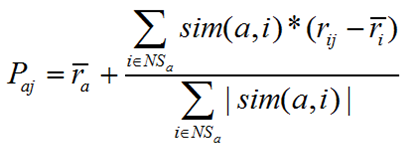

# 完成電影prdiction預測部分

In [ ]:
#將該user有的rating紀錄 map成只有 (watched_mv_ID, normalized rating)
User_watchedMV_rating= watched_movie_record.map(lambda x : (x[1][0], x[1][1]))

#mapper是將其轉成item based 當key ()
user_board = cs_watched_unwatch.leftOuterJoin(User_watchedMV_rating)#.map(lambda x : (x[1][0][0], (x[0], x[1][0][1])))
user_board2 = user_board.map(lambda x : (x[1][0][0], (math.pow(x[1][0][1],2)**0.5,x[1][0][1]* x[1][1])))
user_board2.take(3)
#(沒看過movie_IDwatchMV,  ( |cosine|, cosine* 對有看過電影的評分))

In [ ]:
prediction_without_basedline = user_board2.reduceByKey(lambda x, y : (x[0]+ y[0], x[1]+ y[1])).map(lambda x : (x[0], ( x[1][1]/x[1][0])))
prediction_without_basedline.take(4)

# Add the  basedline


Which basedline?

- movie basedline (採用): 大眾普遍對某電影評分越低，我們預估該user對其評分越低 (Normailized 後的評分會有負值表示不受大眾看好)


- user basedline  : 該user討厭特定類型電影，我們預估期其會給同類型電影分數也越低 (baseline為該user平均評分)

        缺點: 若是只有評分太少(例如都是平價兩個3分) 則我們容易讓其預測評分 太高

並且確保加上based後不會低於0分或是高於5分

In [ ]:
def rating_revised(score):
    
    """
    若是加上basedline調整後的分數大於5或是小於0則進行調整
    """
    revised_score = 0.0
    if (score) < 0.0:
        revised_score = 0.0
    elif(score > 5.0):
        revised_score = 5.0
    else:
        revised_score = score
    return revised_score   

#### movie basedline

In [ ]:
#item based 算法
#計算該電影normailzed rating總得分/ 總評分人數
item_based_line = user_based_Nlrating.map(lambda x : (x[1][0],(x[1][1],1))).reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1]))\
                    .map(lambda x : (x[0], x[1][0]/x[1][1]))
item_based_line.take(5)
# prediction_without_basedline.take(10)


In [ ]:
prediction = prediction_without_basedline.leftOuterJoin(item_based_line)\
                                    .map(lambda x : (x[0], rating_revised(x[1][0]+x[1][1])))
prediction.take(5)

In [ ]:
prediction.take(10)

#### user based line部分

In [ ]:
#caculate the rating mena of user
#user based line
user_rating_mean = ratings_data_pairedRDD.filter(lambda x : (x[0]== specificed_user_id)).map(lambda x: (x[0],(x[1][1], 1)))\
                    .reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1]))\
                    .map(lambda x : (x[0], x[1][0]/x[1][1]))
user_rating_mean.take(2)                         

In [ ]:
#加上basedline

prediction = prediction_without_basedline.map(lambda x : (specificed_user_id, (x[0], x[1]))).join(user_rating_mean)\
            .map(lambda x : (x[1][0][0], rating_revised(x[1][0][1]+ x[1][1])))
prediction.take(1)



In [ ]:
#預測分數完成  (我們採用movie based 的 based line)

In [ ]:
prediction.cache()

In [ ]:
# 找出movie ID

In [ ]:

#指定推薦數量 num_recomd = 500
num_recomd = 500
print(f'The top {num_recomd} recommended movies list for user{specificed_user_id} as below:')

order_prediction = prediction.top(num_recomd, key=lambda x: x[1])
order_prediction

# 步驟說明停止, 下面為推薦系統function


In [ ]:
#建立該movie  titile的字典    
dic_titile =  movies_data_pairedRDD.map(lambda x : (x[0], x[1][0])).collect()
mov_title_dict = {ele[0] : ele[1] for ele in dic_titile}

def get_title(n):
    """
    input sorted_rdd的k2位置(有看過的電影ID) 將自動去dict中找到對應的title
    
    """
    #建立該user評分紀錄的字典    
    result = mov_title_dict.get(n)
    return result
def ID_2_Title(ls):
    """
    input為list
    呼叫get_title，執行print
    """
    for (x,y) in ls:
        a = get_title(x)
        print(f'MovieID: {x}; Title: {a}; Predicted Rating: {y}')
              

In [ ]:
def order_rddkey(turple):
    """
    表示以沒有看過的電影為key
    傳入top10電影關係的cosine sim的key pair，將其重新組合，有看過電影的ID放後面
    """
    if turple[0] not in watched_movie_list: 
        out = (turple[0], turple[1])
    else:
        out = ( turple[1], turple[0])
    return out

def top10(ls,i):
    """
    傳入由tuple組成的list，依照tuple中x[1]位置(cos- sim)大小，由高至低倒序排列
    """
    ls.sort(key= lambda x: -x[1]) 
    ls =  ls[:i]
    return ls

def rating_revised(score):
    
    """
    若是加上basedline調整後的分數大於5或是小於0則進行調整
    """
    revised_score = 0.0
    if (score) < 0.0:
        revised_score = 0.0
    elif(score > 5.0):
        revised_score = 5.0
    else:
        revised_score = score
    return revised_score   

In [ ]:
# #1.: 輸入指定user ID,從user_based_Nlrating filter出該user的評分紀錄
# specificed_user_id = 1 #這也同時是之後要求的input
# num_recomd = 500 #指定推薦數量 num_recomd = 500
# top_i_in_cosine = 10 #mov_i(未看過)與mov_j(看過), movi對任一電影movj 之cosine similarity 前10計入預測分數


"""
此程式不stable, demo請從步驟部分開始，一樣能夠設定參數
"""

def recommendation_sys(specificed_user_id,num_recomd =500, top_i_in_cosine = 10):
    watched_movie_record  = user_based_Nlrating.filter(lambda x :(x[0] == specificed_user_id))
    #從user_based_Nlrating filter出該user的評分紀錄
    print(f'stage 1 completed')
    """
    目標是從cosin_sim中只取出會用到的的關係，加速運算速度,因此只針對 ((k1, k2), cos-sim),
    K1或是k2其中一部電影是看過，另一部是沒有看過的篩選出來
    """
    #2.  從cosine similarity (cosin_sim)結果中取出key中有該user看過電影的cos - sim
    print(f'stage 2 completed')
    ##2-1. 將該user有看過電影裝在list中
    watched_movie_list = watched_movie_record.map(lambda x : (x[1][0])).collect()
    
    ##2-2.   從cosine similarity 結果中取出key中有該user看過電影的cos，放在cosine sim 中
    #取出cosin_sim中key pair任一值為該user看過的電影，且另一部電影為沒看過的cosine 關係
    cosine_index = cosin_sim.filter(lambda x : ((x[0][1]) in watched_movie_list and x[0][0] not in watched_movie_list) or ((x[0][0]) in watched_movie_list and x[0][1] not in watched_movie_list ))
    cosine_index.take(1)
    cosine_index.cache()
    print(f'stage 3 completed')

    """
    select out the required cosine sim relatonship =: Default top 10
    """
    #目標是將key pair整理好，
    #.map(lambda x : (x[0][1],(x[0][0], x[1]))) 部分則是將其mapping 成以有看過的電影為single key, value= (沒看過的電影ID, cos - sim)
    cs_watched_unwatch   =cosine_index.map(lambda x : (order_rddkey(x[0]),x[1])).map(lambda x : (x[0][1],(x[0][0], x[1])))
    print(f'stage 4 completed')

    #cs_watched_unwatch format原本為(看過的電影ID (沒看過movie_ID，cosine))
    #透過此mapper將其轉化成 ((沒看過movie_ID,看過的電影ID),cosine )
    tt1 = cs_watched_unwatch.map(lambda x : (int(x[1][0]), (int(x[0]), x[1][1])))
    tt1.cache()
    print(f'stage 5 completed')

    #先以未看過電影ID為key, group起來, group起來部分會是以tuple形式組組成的RDD，因此要轉list
    stupid_python = tt1.groupByKey().map(lambda x : (x[0], list(x[1])))
    stupid_python.take(1)
    print(f'stage 6 completed')

    #找出cosine互相為前十個的關係
    top_10__call = stupid_python.map(lambda x : (x[0],top10(x[1],top_i_in_cosine)))
    print(f'stage 7 completed')
    top_10__call.take(1)
    print(f'stage 7.5 completed')

    #還原flatmap
    recovery = top_10__call.flatMapValues(lambda x : (x))
    recovery.take(1)
    print(f'stage 8 completed')

    #轉回cs_watched_unwatch#(未看過的電影, (看過的電影, movie rating)) okay
    cs_watched_unwatch = recovery.map(lambda x : (int(x[1][0]), (int(x[0]), float(x[1][1]))))
    cs_watched_unwatch.take(1)
    print(f'stage 9 completed')

    """
    Prediction Part
    """
    #將該user有的rating紀錄 map成只有 (watched_mv_ID, normalized rating)
    User_watchedMV_rating= watched_movie_record.map(lambda x : (x[1][0], x[1][1]))
    User_watchedMV_rating.take(1)
    print(f'stage 10 completed')
    
    #mapper是將其轉成item based 當key ()   #應該是這
    user_board = cs_watched_unwatch.leftOuterJoin(User_watchedMV_rating)#.map(lambda x : (x[1][0][0], (x[0], x[1][0][1])))
    user_board2 = user_board.map(lambda x : (x[1][0][0], (math.pow(x[1][0][1],2)**0.5,float(x[1][0][1])* float(x[1][1]))))

    user_board2.take(1)
    print(f'stage 12 completed')

    prediction_without_basedline = user_board2.reduceByKey(lambda x, y : (x[0]+ y[0], x[1]+ y[1]))\
                                    .map(lambda x : (x[0], ( x[1][1]/x[1][0])))
    prediction_without_basedline.take(1)
    print(f'stage 13 completed')

    """
    item adding based line
    
    """
    item_based_line = user_based_Nlrating.map(lambda x : (x[1][0],(x[1][1],1))).reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1]))\
                    .map(lambda x : (x[0], x[1][0]/x[1][1]))
    prediction = prediction_without_basedline.leftOuterJoin(item_based_line)\
                                    .map(lambda x : (x[0], rating_revised(x[1][0]+x[1][1])))
      
    """
    User adding based line
    
    """
    
#     user_rating_mean = ratings_data_pairedRDD.filter(lambda x : (x[0]== specificed_user_id)).map(lambda x: (x[0],(x[1][1], 1)))\
#                         .reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1]))\
#                         .map(lambda x : (x[0], x[1][0]/x[1][1]))
#     user_rating_mean.take(1)
#     print(f'stage 14 completed')

#     prediction = prediction_without_basedline.map(lambda x : (specificed_user_id, (x[0], x[1]))).join(user_rating_mean)\
#             .map(lambda x : (x[1][0][0], rating_revised(x[1][0][1]+ x[1][1])))
    
    prediction.cache()
    prediction.take(1)
    print(f'stage 15 completed')
    
    order_prediction = prediction.top(num_recomd, key=lambda x: x[1])
    print(f'stage 16 completed')

    print(f'The top {num_recomd} recommended movies list for user{specificed_user_id} as below:')
    result = ID_2_Title(order_prediction)
    print(result) 


In [ ]:
#1.: 輸入指定user ID,從user_based_Nlrating filter出該user的評分紀錄
idd =4 #user ID
n = 500 #指定推薦數量 num_recomd = 500
#top_i_in_cosine = 10 #mov_i(未看過)與mov_j(看過), movi對任一電影movj 之cosine similarity 前10計入預測分數
po = recommendation_sys(idd,num_recomd =500, top_i_in_cosine = 10)
po

# Part III 使用ALS重寫


利用RDD基於model based算法- ALS來達矩陣分解，讓速度更快。

此部分算法與上述算法獨立，可以單獨執行，可於完成spark 基本環境設定(第一段程式碼)單獨執行，用於加分。

In [ ]:
#input file path setting
movies_file_path = 'C:\\Users\\LeoShr\\p_space\\NTHU\\MDA\\Team Project\\Dataset\\ml-latest-small\\' + 'movies.csv'
ratings_file_path = 'C:\\Users\\LeoShr\\p_space\\NTHU\\MDA\\Team Project\\Dataset\\ml-latest-small\\' + 'ratings.csv'
#完成rating斷行，跟上面完全一樣
ratings_raw_data = sc.textFile(ratings_file_path)

ratings_header =  ratings_raw_data.take(1)[0]
ratings_data_RDD = ratings_raw_data.filter(lambda x: x != ratings_header).map(lambda x: x.split(",")).map(lambda t: (int(t[0]), int(t[1]), float(t[2])))

#完成movie斷行，跟上面完全一樣
movies = sc.textFile(movies_file_path)
movies_header = movies.take(1)[0]
complete_movies_data = movies.filter(lambda x: x != movies_header).map(lambda x: x.split(",")).map(lambda tokens: (int(tokens[0]), tokens[1], tokens[2])).cache()
complete_movies_titles = complete_movies_data.map(lambda x: (int(x[0]),x[1]))

# 將資料拆成training set,  test set , validation set

這樣才能用validation測試

In [ ]:
training_set, validation_set, test_set = ratings_data_RDD.randomSplit([0.7, 0.15, 0.15])

 ## 只放user id, movie_id ，移除rating

In [ ]:
validation_set = validation_set.map(lambda x: (x[0], x[1])) #只放user id, movie_id ，移除rating
test_set = test_set.map(lambda x: (x[0], x[1]))

# 

In [ ]:
from pyspark.mllib.recommendation import ALS

In [ ]:
seed, iterations, lr = 111, 10, 0.1
#MinError先設為無限大，之後會往下取代
errors = [0, 0, 0]
temp = 0 
MinError = float('inf')
#Desired_rank先隨便設一個非正數值，等等會從ranks list中取值取代
ranks, Desired_rank = [4, 8, 12], -1

# 利用ALS找出擁有最小EMSE的 Rank 值 


### Rank值表示latent factor數量

In [ ]:
for rank in ranks:
    
    #先將training set用來fit model, 通常iterations <20、 seed隨便、lambda 是 正則化的參數(具體我不知)
    #模型會丟出model參數 : DataType為<pyspark.mllib.recommendation.MatrixFactorizationModel的matrix

    ALS_model = ALS.train(training_set, rank, seed=seed, iterations=iterations, lambda_=lr)
    print('completed model')
    
    """
    validation_set
    """
    #使用fit好的模型對validation set作預測，並map成以user, movieID作key
    #(Foramt: (user id, movie_id) )
    predictions = ALS_model.predictAll(validation_set).map(lambda x: ((x[0], x[1]), x[2]))
    #predictions format= [Rating(user id, movie_id, Predicted rating),....] ，
    print('predictions completed')
    
    #用map整理好，以 (user id, movie_id)為key，等等跟真正的rating做inner join 
    temp = validation_set.map(lambda x: ((int(x[0]), int(x[1])), float(x[2])))
    predictions_result = predictions.join(temp)
    print('Join completed')
    
    #計算與實際rating的RSME，目標是取出最小RSME的Rank當作latent factor數量
    error = math.pow(predictions_result.map(lambda x: (x[1][0] - x[1][1]) ** 2).mean(), 0.5)
    print(f'Error completed, as rank equal to {rank}')
    #依序放入error list，temp = 0,1,2,3...
    errors[temp] = error 
    temp += 1
    #只要該errors[err]值小於目前最低的最小error (MinError)就取代MinError
    if error < MinError:
        Desired_rank = rank
        MinError = error
    print(f'Rank: {rank}; RMSE Error: {error}')
          
    
print("\n\n")
print('Best Rank: {}'.format(Desired_rank))

In [ ]:
print(f'UwrId    mov_Id    Real.R     Estimated.R')
recom_mum = 5
for i in predictions_result.take(recom_mum):
    print(f'{i[0][0]}\t{i[0][1]}\t {i[1][0]}\t{round(i[1][1],5)}')

## Testing Set

使用test_set驗證，得到predictions_result:  0.9089997788892856

In [ ]:
ALS_model = ALS.train(training_set, Desired_rank, seed=seed, iterations=iterations, lambda_=lr)
# 模型會丟出model參數 : DataType為<pyspark.mllib.recommendation.MatrixFactorizationModel的matrix

##對testing set進行預測
#input=test_set(Foramt: (user id, movie_id) )
predictions = ALS_model.predictAll(test_set).map(lambda x: ((x[0], x[1]),x[2]))
# 模型會丟出DataType為<pyspark.mllib.recommendation.MatrixFactorizationModel的matrix
#[Rating(user id, movie_id, Predicted rating),....] ，用map整理好，以 (user id, movie_id)為key，等等跟真正的rating做inner join

#將真正的評分與預測分數做inner join
temp = test_set.map(lambda r: ((r[0], r[1]), float(r[2])))
predictions_result = temp.join(predictions)

#format: ((使用者, 電影), (真實分數, 預測分數))

#計算預測分數與實際分數的√avg(差的平方)
error = math.pow(predictions_result.map(lambda r: (r[1][0] - r[1][1]) ** 2).mean(), 0.5)
print(f'test set ERROR: {error}')

# 將預測分數與我先前計算出來預測的分數作平均

***將先前PartII指定推薦推薦之結果(predcited rating)與此模型萬出之預測rating做平均值，作為優化。***



Started at 12/25 20:30

# 更動項目log:



1. (Completed)改動ID為數字，節省內存
    - (Designed at 12/25 20:30)


2. (Completed)確定cosin_sim = numerator_sum.leftOuterJoin(denominator_formatted) failed原因不是超時，而是partition設定問題
   -  利用設定master( local[4]) 取代原本的master( local*)，資料分太細，crashed
   - (Designed at 12/25 16:30)
   
   
3. (Completed) 重新設計分母取代卡式積的可能性? 
    - (1) 不! 我們應該當分子為0 或是不存在該關係時，直接返回cosine為0? Nope 無法
    - (2) 分子的RDD key先.leftjoin分母((mv1, mv2), rating))，這樣分子不存在的部分之後就不用跟分子join，直接大幅減少分母的row數
          Done
          
          
4. (Completed) 
    - 發現Output 有很多是成對的，例如是 ((1,2),0.33), ((2,1),0.33)這些是不需要的，有什麼辦法讓我們一開始就不會要計算算同樣的關係?
        有，先各自filter
    - 當mv_id 相等時，不用計算，因為cosine必定為1，不列出比較
    
    
    
5. (Completed) cosine similarity 顯示時會有同4點的問題，如何將相同關係的movie- movie只留下唯一一個，並去除自己對自己的關係ex.(1,1)?
   關鍵字: 顯示優化  
   
   - (Designed at 12/25 23:00)
6. (Completed)執行第三次real data 計算(12/25 23:00  )
   - 會crashed
   
7. (Completed)已經利用pandas算出item- based的 相關係數， 可以之後當作欄位corr送進去train
8. (Completed)已經利用pyspark mllib利用ALS 訓練， 可利用該結果當作欄位ALS送進去train

9. (Completed)重新確定item based算法是否正確


10. (Completed) 額外用sklearn依照item based要求設計出推薦系統了，想辦法將其重寫成RDD mapreduce算法
 - (Designed at 12/28 01:30)
11. (Completed) 重要更動去除原先設計的normalized算法: item based 算normalized cosine可能導致原先存在cosine dis變成不存在 '0'

12. (Completed)完工 不確定推薦分數是否正確 - (Designed at 12/27 20:55)

13. (Ongoing) 確定用real data可以跑得動 (創新文件跑) 

- 卡在leftOuterJoin , 進行優化 - (Designed at 12/29 5:30 排除)

14. (Pending)block 3常常用run all會error，要手動，原因不明

15. (Completed) Socket overtime  setting
-  (Designed at 12/29 6:45 排除)


16. 找到論文連結:
https://www.ra.ethz.ch/cdstore/www10/papers/pdf/p519.pdf

17. (Completed) 進算法重新設計，完成到分子分母主測資能跑
-  (Designed at 12/30 00:45 排除)
18. (Completed) 進行將分子測資重新partition，但是不shuffle，完成partition num調整
-  (Designed at 12/31 03:13 排除)

19. (Completed) Part1完全可以在local運行

20. (Completed) 重寫cosine denominator算法，優化成原先1/3耗時，並確保Part I結果完全不會time out, Error
-  (Designed at 01/04 11:45 )

21. (Completed) 利用AWS EMR運行 Part II okay
-  (Designed at 01/04 14:35 )

22. (Completed) 驗算Part I 
-  (Designed at 01/05 03:05 )

24. (Completed)(推薦系統部分重寫) 

- (Designed at 01/05 22:14 )